# DEPENDENCIES

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA

In [4]:
def plot_acf(df, col):
    fig, axes = plt.subplots(2, 2, figsize=(24, 6))
    ax1, ax2, ax3, ax4 = axes.flatten()

    sm.graphics.tsa.plot_acf(df[col].values.squeeze(), lags=20, ax=ax1)
    ax1.set_title(f"{col}: ACF of Original Data")

    sm.graphics.tsa.plot_acf(df[col].diff().dropna().values.squeeze(), lags=20, ax=ax2)
    ax2.set_title(f"{col}: ACF of Differenced Data")

    sm.graphics.tsa.plot_pacf(df[col].values.squeeze(), lags=20, ax=ax3)
    ax3.set_title(f"{col}: PACF of Original Data")
    sm.graphics.tsa.plot_pacf(df[col].diff().dropna().values.squeeze(), lags=20, ax=ax4)
    ax4.set_title(f"{col}: PACF of Differenced Data")

    plt.tight_layout()

    plt.show()

# READ DATA

In [5]:
data = pd.read_csv(
    "C:/Users/edmun/OneDrive/Desktop/2025-IMC-Global-Trading-Challenge/Backtest/resources/round0/prices_round_0_day_-2.csv",
    sep=";",
)

In [6]:
data["most_bid_volume"] = data[["bid_volume_1", "bid_volume_2", "bid_volume_3"]].idxmax(
    axis=1
)
data["most_ask_volume"] = data[["ask_volume_1", "ask_volume_2", "ask_volume_3"]].idxmax(
    axis=1
)
data["most_bid"] = np.where(
    data["most_bid_volume"] == "bid_volume_1",
    data["bid_price_1"],
    np.where(
        data["most_bid_volume"] == "bid_volume_2",
        data["bid_price_2"],
        np.where(
            data["most_bid_volume"] == "bid_volume_3", data["bid_price_3"], np.nan
        ),
    ),
)

data["most_ask"] = np.where(
    data["most_ask_volume"] == "ask_volume_1",
    data["ask_price_1"],
    np.where(
        data["most_ask_volume"] == "ask_volume_2",
        data["ask_price_2"],
        np.where(
            data["most_ask_volume"] == "ask_volume_3", data["ask_price_3"], np.nan
        ),
    ),
)

data["most_bid_volume"] = data[["bid_volume_1", "bid_volume_2", "bid_volume_3"]].max(
    axis=1
)
data["most_ask_volume"] = data[["ask_volume_1", "ask_volume_2", "ask_volume_3"]].max(
    axis=1
)

data["most_mid"] = (data["most_ask"] + data["most_bid"]) / 2

data["most_micro"] = (
    data["most_ask"] * data["most_bid_volume"]
    + data["most_bid"] * data["most_ask_volume"]
) / (data["most_ask_volume"] + data["most_bid_volume"])


data["micro_price"] = (
    data["ask_price_1"] * data["bid_volume_1"]
    + data["bid_price_1"] * data["ask_volume_1"]
) / (data["ask_volume_1"] + data["bid_volume_1"])


data["ask_vwap"] = (
    data["ask_price_1"] * data["ask_volume_1"]
    + data["ask_price_2"] * data["ask_volume_2"]
    + data["ask_price_3"] * data["ask_volume_3"]
) / (data["ask_volume_1"] + data["ask_volume_2"] + data["ask_volume_3"])

data["bid_vwap"] = (
    data["bid_price_1"] * data["bid_volume_1"]
    + data["bid_price_2"] * data["bid_volume_2"]
    + data["bid_price_3"] * data["bid_volume_3"]
) / (data["bid_volume_1"] + data["bid_volume_2"] + data["bid_volume_3"])

data["vwap_mid"] = (data["ask_vwap"] + data["bid_vwap"]) / 2

In [7]:
prices = [
    "mid_price",
    "most_mid",
    "most_micro",
    "micro_price",
    "vwap_mid",
]

# Resin

In [8]:
resin = data[data["product"] == "RAINFOREST_RESIN"].fillna(0)

## KELP

In [32]:
kelp = data[data["product"] == "KELP"].fillna(0)

In [10]:
kelp

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,most_bid_volume,most_ask_volume,most_bid,most_ask,most_mid,most_micro,micro_price,ask_vwap,bid_vwap,vwap_mid
1,-1,0,KELP,2028,1,2026.0,2.0,2025.0,29.0,2029,...,29.0,31.0,2025.0,2029.0,2027.0,2026.933333,2028.031250,0.000000,2025.15625,0.0
2,-1,100,KELP,2025,24,0.0,0.0,0.0,0.0,2028,...,24.0,22.0,2025.0,2029.0,2027.0,2027.086957,2027.769231,0.000000,0.00000,0.0
5,-1,200,KELP,2025,22,0.0,0.0,0.0,0.0,2028,...,22.0,20.0,2025.0,2028.0,2026.5,2026.571429,2026.571429,0.000000,0.00000,0.0
6,-1,300,KELP,2025,31,0.0,0.0,0.0,0.0,2028,...,31.0,29.0,2025.0,2029.0,2027.0,2027.066667,2027.818182,0.000000,0.00000,0.0
9,-1,400,KELP,2025,27,0.0,0.0,0.0,0.0,2028,...,27.0,27.0,2025.0,2028.0,2026.5,2026.500000,2026.500000,0.000000,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990,-1,199500,KELP,2020,23,0.0,0.0,0.0,0.0,2024,...,23.0,23.0,2020.0,2024.0,2022.0,2022.000000,2022.000000,0.000000,0.00000,0.0
3992,-1,199600,KELP,2020,22,0.0,0.0,0.0,0.0,2023,...,22.0,21.0,2020.0,2024.0,2022.0,2022.046512,2022.869565,0.000000,0.00000,0.0
3995,-1,199700,KELP,2020,27,0.0,0.0,0.0,0.0,2023,...,27.0,25.0,2020.0,2024.0,2022.0,2022.076923,2022.793103,0.000000,0.00000,0.0
3997,-1,199800,KELP,2020,21,0.0,0.0,0.0,0.0,2023,...,21.0,21.0,2020.0,2023.0,2021.5,2021.500000,2021.500000,0.000000,0.00000,0.0


### ACF / PACF PLOT
Slow decay in ACF => time series not stationary => Differencing required

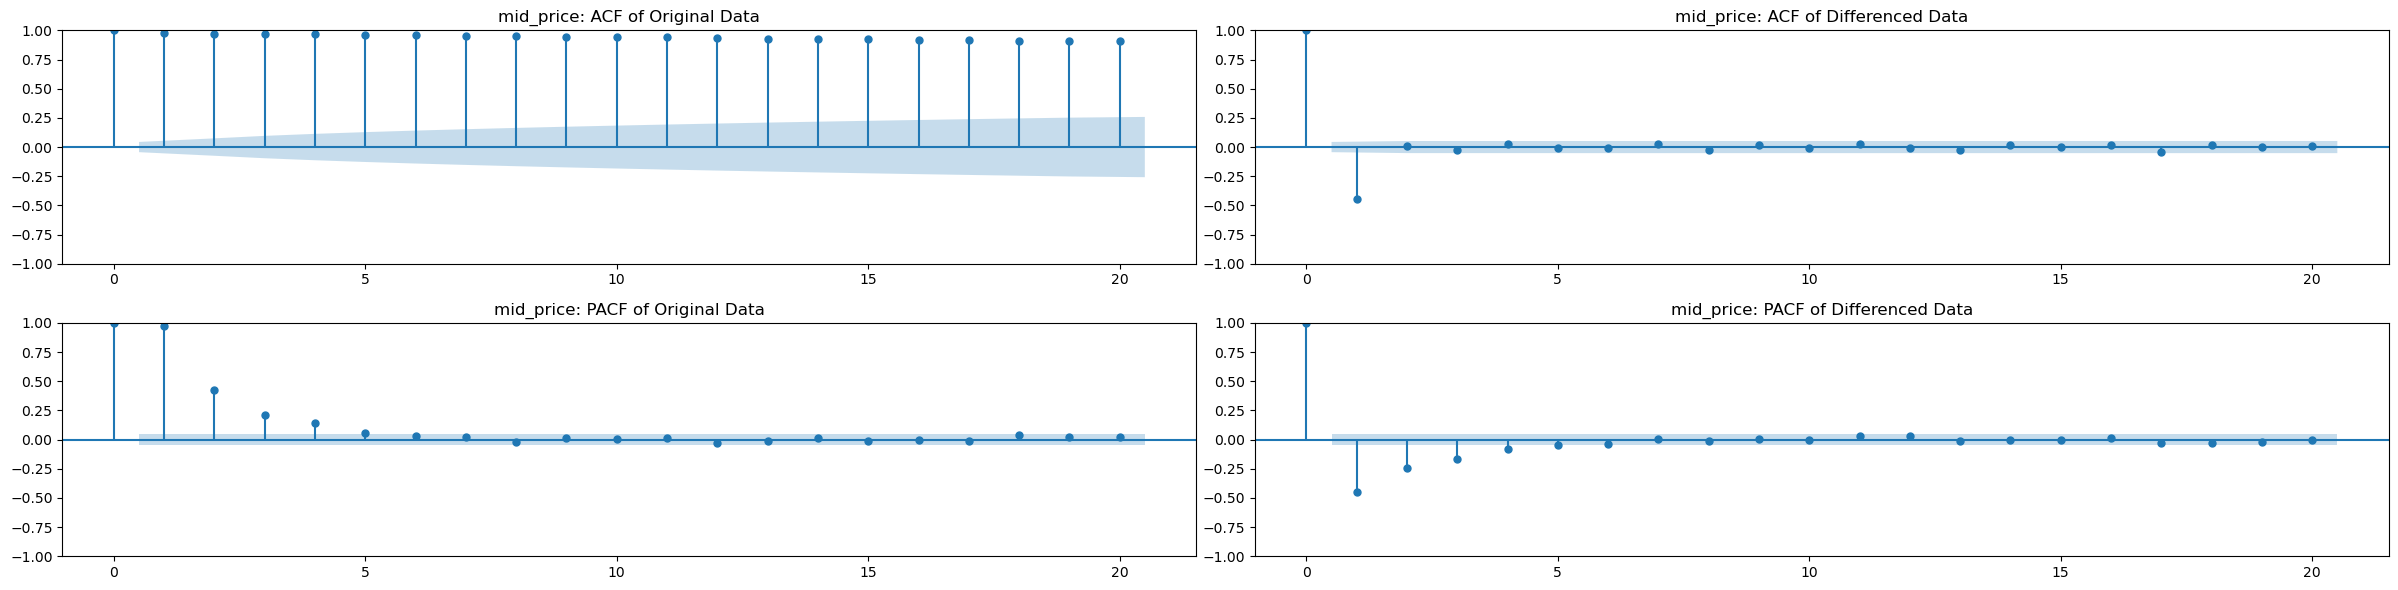

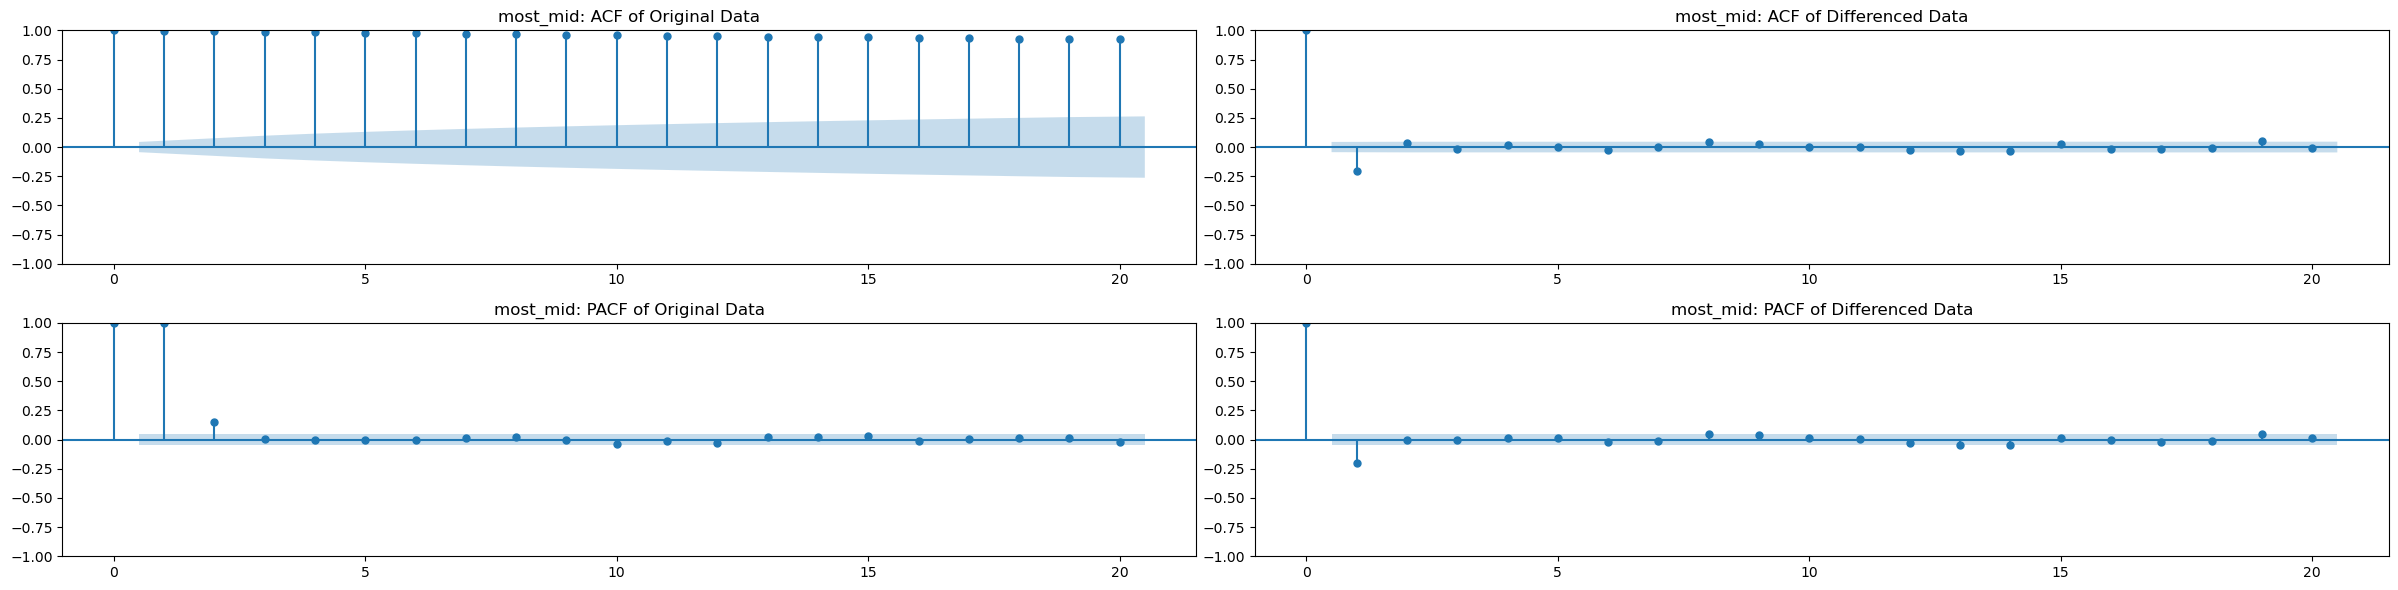

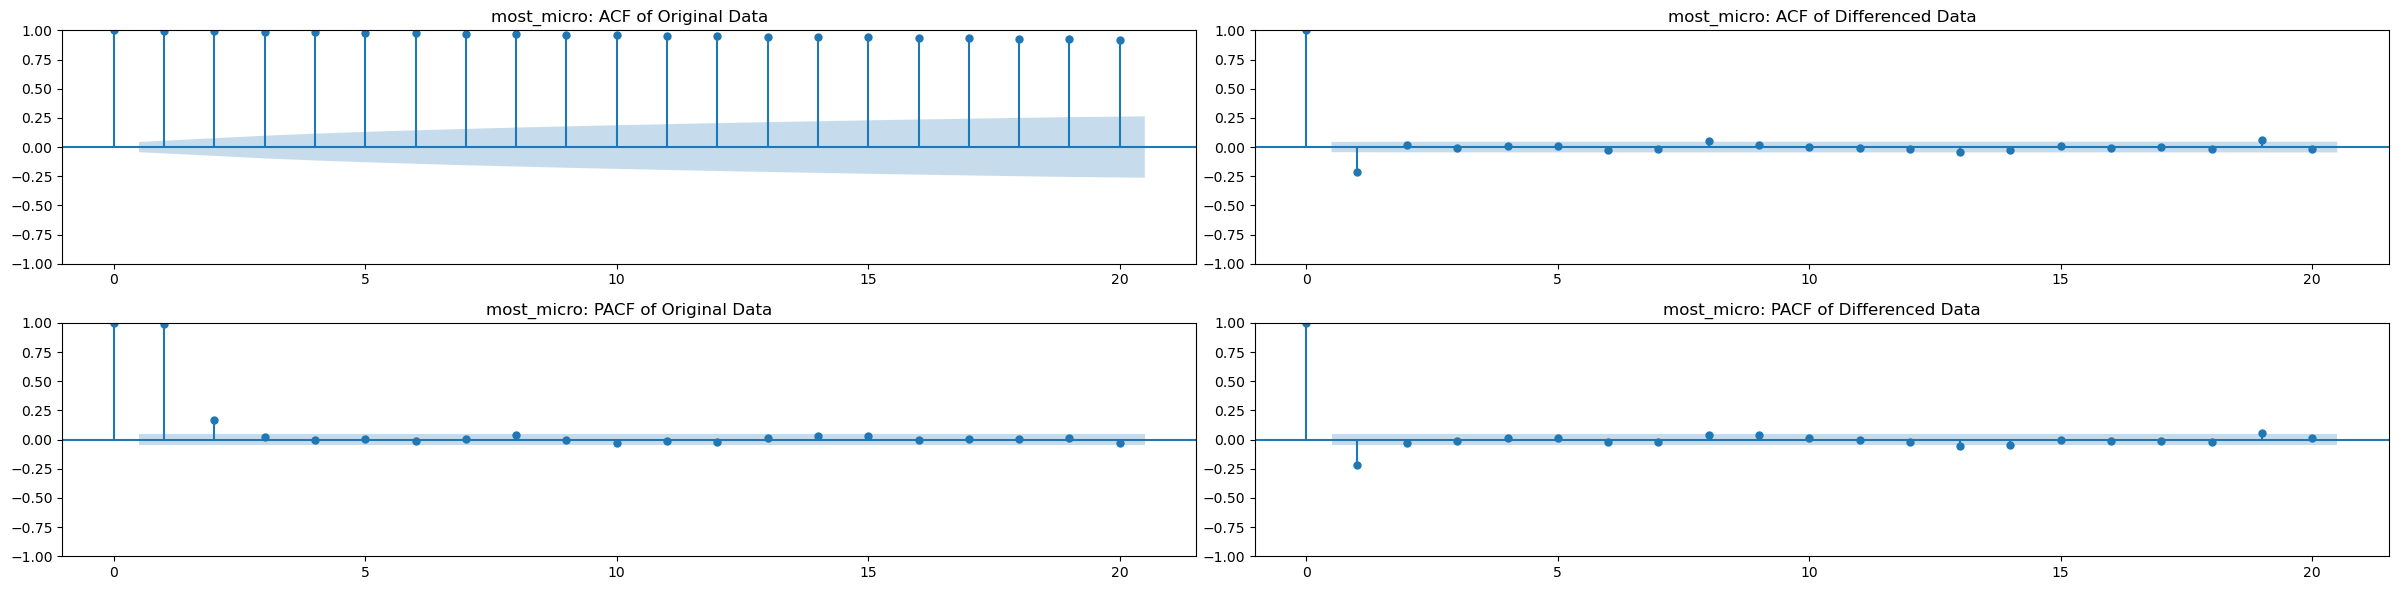

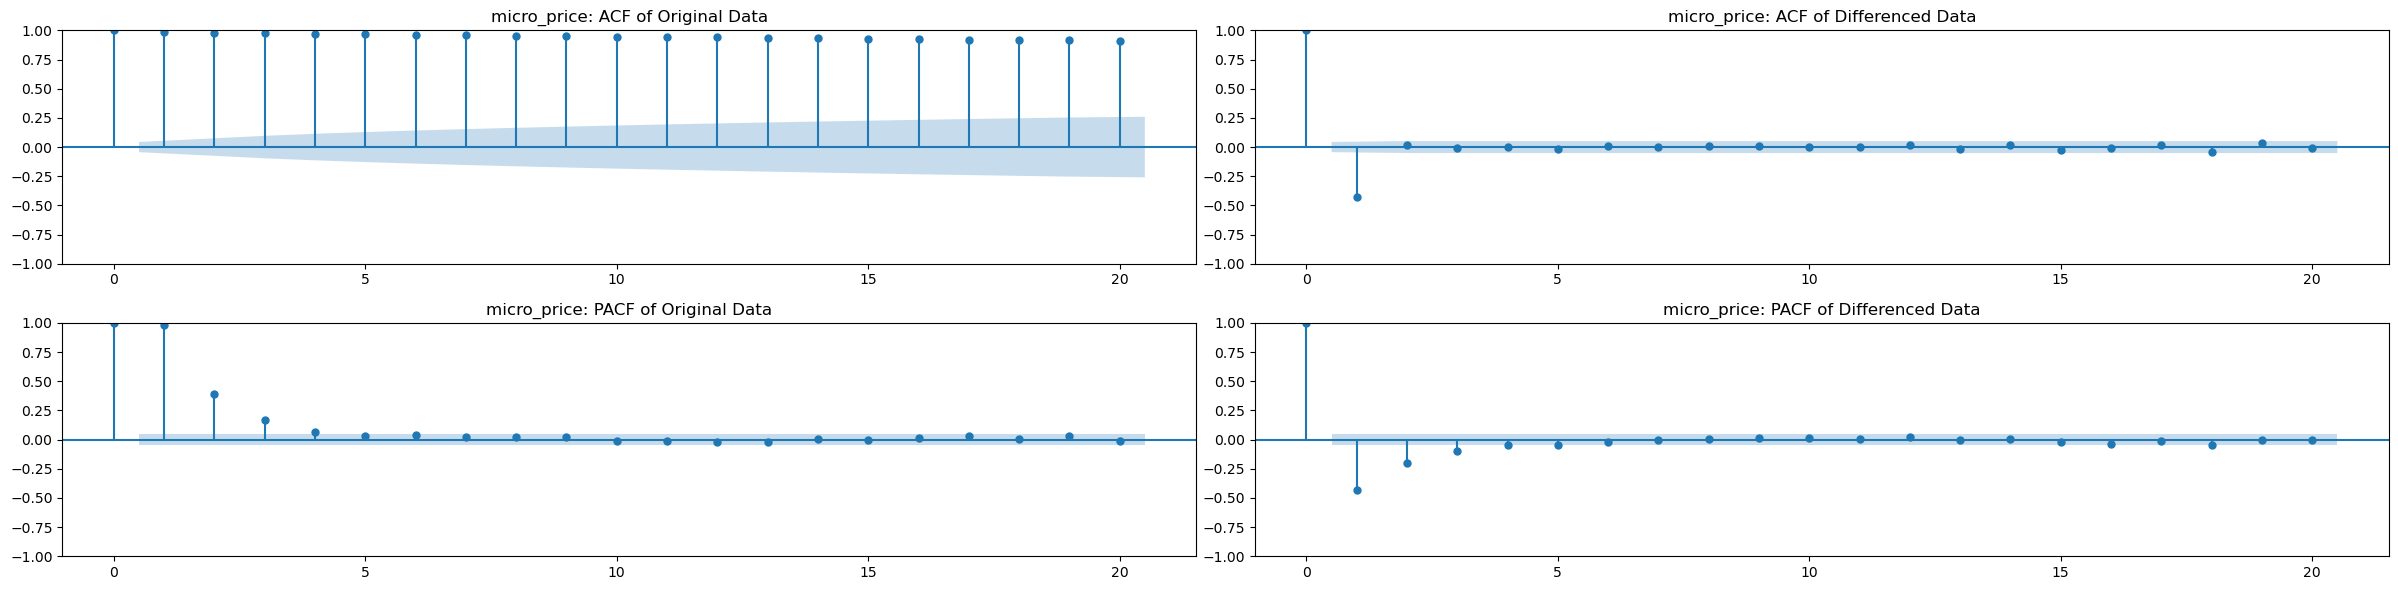

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1491: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1491: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


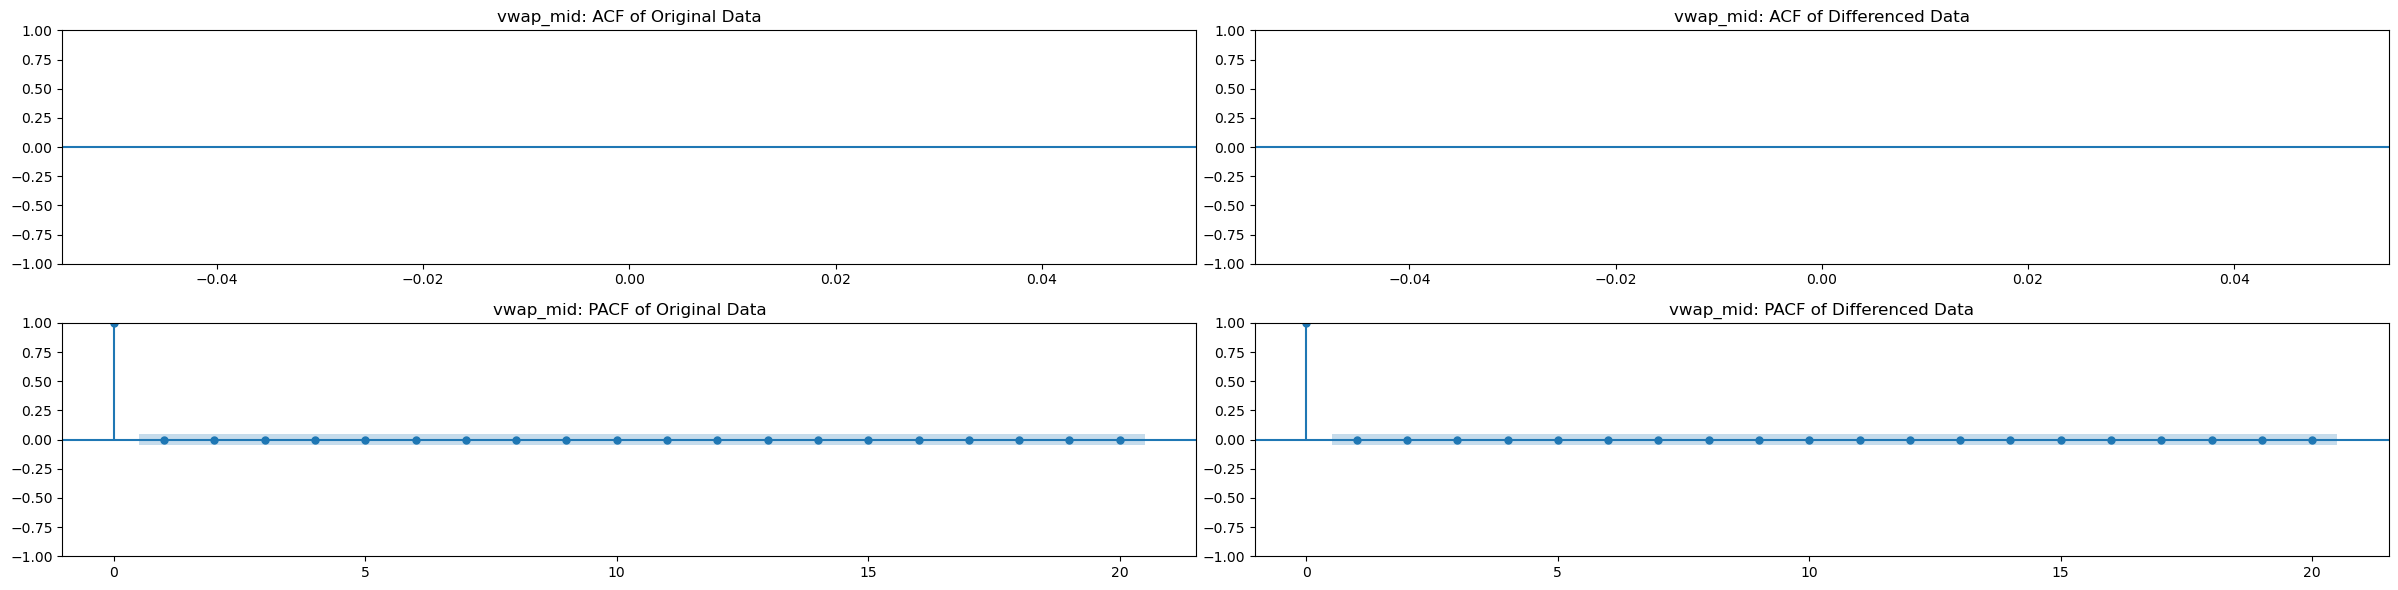

In [11]:
for price in prices:
    plot_acf(df=kelp, col=price)

After differencing, observe a 1 lag before sharp drop => differenced time series follows MA(1) \
This is confirmed by the exponentional decay in PACF of differenced time series

## MA(1) MODEL

## Single Factor
Running MA(1) model on 1 Endogeneous variable

In [12]:
for price in prices:
    print(f"########################   {price}   ##########################")
    arima = ARIMA(endog=kelp[price].values, order=(0, 1, 1)).fit()
    print(arima.summary())

########################   mid_price   ##########################
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2015.122
Date:                Tue, 25 Mar 2025   AIC                           4034.244
Time:                        22:41:16   BIC                           4045.445
Sample:                             0   HQIC                          4038.357
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6131      0.016    -37.491      0.000      -0.645      -0.581
sigma2         0.4396      0.012     36.205      0.000       0.41

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1420: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


## Single factor with exogeneous variable
Running MA(1) model on 1 Endogeneous variable + 1 Exogeneous variable

In [13]:
for price in prices[1:]:
    print(
        f"########################   MID_PRICE + {price}   ##########################"
    )
    arima = ARIMA(
        endog=kelp["mid_price"].values,
        exog=kelp[price].diff().fillna(0).values,
        order=(0, 1, 1),
    ).fit()
    print(arima.summary())

########################   MID_PRICE + most_mid   ##########################
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1945.116
Date:                Tue, 25 Mar 2025   AIC                           3896.233
Time:                        22:41:17   BIC                           3913.034
Sample:                             0   HQIC                          3902.402
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4554      0.036     12.633      0.000       0.385       0.526
ma.L1         -0.5962      0.017    -35.886      0.000

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3014: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse


## Single factor with multiple exogeneous variables
Running MA(1) model on 1 Endogeneous variable + multiple exogeneous variable

In [14]:
from itertools import combinations

for i in range(2, 5):
    for combi in combinations(prices[1:], i):
        print(
            f"########################   MID_PRICE + {combi}   ##########################"
        )
        arima = ARIMA(
            endog=kelp["mid_price"].values,
            exog=kelp[list(combi)].diff().fillna(0).values,
            order=(0, 1, 1),
        ).fit()
        print(arima.summary())

########################   MID_PRICE + ('most_mid', 'most_micro')   ##########################
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1944.144
Date:                Tue, 25 Mar 2025   AIC                           3896.288
Time:                        22:41:18   BIC                           3918.690
Sample:                             0   HQIC                          3904.514
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6626      0.161      4.105      0.000       0.346       0.979
x2            -0.2055      0.158    

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3014: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1953.429
Date:                Tue, 25 Mar 2025   AIC                           3914.857
Time:                        22:41:19   BIC                           3937.259
Sample:                             0   HQIC                          3923.083
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4120      0.035     11.644      0.000       0.343       0.481
const               0         -0        nan        nan           0           0
ma.L1         -0.5989      0.016    -36.322      0.0

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3014: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse


## Potential Models

In [15]:
arima = ARIMA(
    endog=kelp["mid_price"].values,
    exog=kelp["micro_price"].diff().fillna(0).values,
    order=(0, 1, 1),
).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1872.768
Date:                Tue, 25 Mar 2025   AIC                           3751.536
Time:                        22:41:21   BIC                           3768.337
Sample:                             0   HQIC                          3757.705
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3068      0.015     20.547      0.000       0.278       0.336
ma.L1         -0.5687      0.017    -32.584      0.000      -0.603      -0.535
sigma2         0.3812      0.011     33.805      0.0

In [16]:
arima.params

array([ 0.30679742, -0.56871383,  0.3812184 ])

In [17]:
arima = ARIMA(
    endog=kelp["mid_price"].values,
    exog=kelp[list(("most_mid", "micro_price"))].diff().fillna(0).values,
    order=(0, 1, 1),
).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1869.078
Date:                Tue, 25 Mar 2025   AIC                           3746.156
Time:                        22:41:21   BIC                           3768.558
Sample:                             0   HQIC                          3754.382
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1211      0.040      3.019      0.003       0.042       0.200
x2             0.2722      0.018     15.373      0.000       0.237       0.307
ma.L1         -0.5687      0.018    -32.384      0.0

In [18]:
arima.params

array([ 0.12107209,  0.27218619, -0.56866306,  0.3798141 ])

In [19]:
arima = ARIMA(
    endog=kelp["mid_price"].values,
    exog=kelp[list(("most_mid", "most_micro", "micro_price"))].diff().fillna(0).values,
    order=(0, 1, 1),
).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1859.470
Date:                Tue, 25 Mar 2025   AIC                           3728.941
Time:                        22:41:22   BIC                           3756.943
Sample:                             0   HQIC                          3739.223
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7270      0.151      4.829      0.000       0.432       1.022
x2            -0.6269      0.152     -4.129      0.000      -0.925      -0.329
x3             0.2934      0.018     16.081      0.0

In [20]:
arima.params

array([ 0.72702633, -0.6269381 ,  0.29338536, -0.56475013,  0.37617876])

In [39]:
import numpy as np
from numba import njit, prange


@njit
def log_likelihood(params, y_diff, X1_diff, X2_diff):
    theta_1, beta_1, beta_2 = params
    sigma2 = 0.3798
    mu = 0

    # Number of observations
    T = len(y_diff)

    ll = -T / 2 * np.log(2 * np.pi * sigma2) - (1 / (2 * sigma2)) * np.sum(
        (
            y_diff[1:]
            - mu
            - theta_1 * y_diff[:-1]
            - beta_1 * X1_diff[1:]
            - beta_2 * X2_diff[1:]
        )
        ** 2
    )

    return -ll


@njit
def gradient(params, y_diff, X1_diff, X2_diff):
    theta_1, beta_1, beta_2 = params
    sigma2 = 0.3798
    mu = 0

    dL_dtheta_1 = (
        np.sum(
            y_diff[:-1]
            * (
                y_diff[1:]
                - mu
                - theta_1 * y_diff[:-1]
                - beta_1 * X1_diff[1:]
                - beta_2 * X2_diff[1:]
            )
        )
        / sigma2
    )
    dL_dbeta_1 = (
        np.sum(
            X1_diff[1:]
            * (
                y_diff[1:]
                - mu
                - theta_1 * y_diff[:-1]
                - beta_1 * X1_diff[1:]
                - beta_2 * X2_diff[1:]
            )
        )
        / sigma2
    )
    dL_dbeta_2 = (
        np.sum(
            X2_diff[1:]
            * (
                y_diff[1:]
                - mu
                - theta_1 * y_diff[:-1]
                - beta_1 * X1_diff[1:]
                - beta_2 * X2_diff[1:]
            )
        )
        / sigma2
    )

    return np.array([-dL_dtheta_1, -dL_dbeta_1, -dL_dbeta_2])


@njit
def gradient_descent(
    y_diff,
    X1_diff,
    X2_diff,
    initial_params,
    learning_rate,
    max_iter=100,
    tolerance=1e-5,
):
    params = np.array(initial_params)
    prev_loss = 1e10
    for i in range(max_iter):
        grad = gradient(params, y_diff, X1_diff, X2_diff)
        loss = log_likelihood(params, y_diff, X1_diff, X2_diff)
        params -= learning_rate * grad

        if prev_loss - loss < tolerance:
            break
        else:
            prev_loss = loss
    return params

In [61]:
interested = 10.5e-5
for _ in range(1000):
    stability = {"theta_1": [], "theta_2": [], "theta_3": []}
    interested += 1e-7
    learning_rate = np.array([7.073e-5, 1.11534e-4, interested]) # np.array([25e-7, 35e-7, 35e-7])
    for i in prange(2_000 - 20):
        y_diff = np.diff(kelp["mid_price"].values)[i : i + 20]
        X1_diff = np.diff(kelp["most_mid"].values)[i : i + 20]
        X2_diff = np.diff(kelp["micro_price"].values)[i : i + 20]

        # Initial guess
        initial_guess = [-0.603, 0.1, 0.237]  # [-0.56866306, 0.12107209, 0.27218619]

        # Run gradient descent to estimate parameters
        estimated_params = gradient_descent(
            y_diff, X1_diff, X2_diff, initial_guess, learning_rate
        )
        stability["theta_1"].append(estimated_params[0])
        stability["theta_2"].append(estimated_params[1])
        stability["theta_3"].append(estimated_params[2])
        
    print(np.median(stability["theta_3"]))

    if abs(np.median(stability["theta_3"]) - 0.27218619) < 0.0001:
        print(np.median(stability["theta_3"]))
        print(interested)
        break

    # print(f"Estimated theta_1: {estimated_params[0]}")
    # print(f"Estimated beta_1: {estimated_params[1]}")
    # print(f"Estimated beta_2: {estimated_params[2]}")


0.27137784258608433
0.2714066202792336
0.2714353914560096
0.2714641561188456
0.27149291427017447
0.27152166591242727
0.27155041104803523
0.27157914967942715
0.27160788180903217
0.27163660743927676
0.2716653265725882
0.27169403921139135
0.27172274535811075
0.27175144501516957
0.2717801381849903
0.2718088248699941
0.271837505072601
0.2718661787952304
0.2718948460403007
0.2719235068102286
0.2719521611074308
0.27198080893432175
0.2720094502933161
0.2720380851868264
0.27206671361726514
0.27209533558704335
0.27209533558704335
0.00010760000000000007


In [63]:
stability = {"theta_1": [], "theta_2": [], "theta_3": []}
learning_rate = np.array([7.073e-5, 1.11534e-4, 1.076e-4])#np.array([2.34e-6, 3.62e-6, 3.46e-6]) # np.array([7.073e-5, 1.11534e-4, 1.076e-4])
for i in prange(2_000 - 20):
    y_diff = np.diff(kelp["mid_price"].values)[i : i + 20]
    X1_diff = np.diff(kelp["most_mid"].values)[i : i + 20]
    X2_diff = np.diff(kelp["micro_price"].values)[i : i + 20]

    # Initial guess
    initial_guess = [-0.603, 0.1, 0.237]  # [-0.56866306, 0.12107209, 0.27218619]

    # Run gradient descent to estimate parameters
    estimated_params = gradient_descent(
        y_diff, X1_diff, X2_diff, initial_guess, learning_rate
    )
    stability["theta_1"].append(estimated_params[0])
    stability["theta_2"].append(estimated_params[1])
    stability["theta_3"].append(estimated_params[2])

print(f"Estimated theta_1: {estimated_params[0]}")
print(f"Estimated beta_1: {estimated_params[1]}")
print(f"Estimated beta_2: {estimated_params[2]}")


Estimated theta_1: -0.5835634396730283
Estimated beta_1: 0.14742131391140526
Estimated beta_2: 0.3344977764119463


In [64]:
print(np.median(stability["theta_1"]), np.std(stability["theta_1"]))
print(np.median(stability["theta_2"]), np.std(stability["theta_2"]))
print(np.median(stability["theta_3"]), np.std(stability["theta_3"]))

-0.5680659525304306 0.029011293353091074
0.11912797283983721 0.02641447430502138
0.2720953355870433 0.060355582165855015


In [31]:
print(np.median(stability["theta_1"]), np.std(stability["theta_1"]))
print(np.median(stability["theta_2"]), np.std(stability["theta_2"]))
print(np.median(stability["theta_3"]), np.std(stability["theta_3"]))

-0.5686988518468932 0.0014227841687657703
0.12093273339328967 0.0013347490041062202
0.27209147811901896 0.002214660460353278


In [65]:
import plotly.express as px

px.histogram(stability["theta_1"])